In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve)

In [2]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/data/cleaned_motor_vehicle_collisions.csv')

In [3]:
display(df.head())
display(df.info())

,borough,crash_date,crash_time,day_of_week,month,is_weekend,hour,hour_category,season,pedestrian_involved,cyclist_involved,vehicle_type_code_1,vehicle_type_code_2,contributing_factor_vehicle_1,contributing_factor_vehicle_2,high_risk,KSI
0,Brooklyn,2023-11-01,01:29:00,2,11,0,1,Late_Night,Fall,0,0,MOPED,SEDAN,UNSPECIFIED,UNSPECIFIED,0,0
1,Queens,2022-09-22,16:16:00,3,9,0,16,Evening_Rush,Fall,0,0,SEDAN,E-SCOOTER,PASSING OR LANE USAGE IMPROPER,UNSPECIFIED,0,0
2,Queens,2023-01-12,21:00:00,3,1,0,21,Night,Winter,0,0,STATION WAGON/SPORT UTILITY VEHICLE,UNKNOWN,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0
3,Brooklyn,2022-07-12,17:50:00,1,7,0,17,Evening_Rush,Summer,0,0,SEDAN,UNKNOWN,OVERSIZED VEHICLE,UNSPECIFIED,0,0
4,Brooklyn,2022-04-24,16:45:00,6,4,1,16,Evening_Rush,Spring,0,0,STATION WAGON/SPORT UTILITY VEHICLE,STATION WAGON/SPORT UTILITY VEHICLE,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342418 entries, 0 to 342417
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   borough                        342418 non-null  object
 1   crash_date                     342418 non-null  object
 2   crash_time                     342418 non-null  object
 3   day_of_week                    342418 non-null  int64 
 4   month                          342418 non-null  int64 
 5   is_weekend                     342418 non-null  int64 
 6   hour                           342418 non-null  int64 
 7   hour_category                  342418 non-null  object
 8   season                         342418 non-null  object
 9   pedestrian_involved            342418 non-null  int64 
 10  cyclist_involved               342418 non-null  int64 
 11  vehicle_type_code_1            342418 non-null  object
 12  vehicle_type_code_2            342416 non-nu

None

In [4]:
df.isna().sum() 

borough                          0
crash_date                       0
crash_time                       0
day_of_week                      0
month                            0
is_weekend                       0
hour                             0
hour_category                    0
season                           0
pedestrian_involved              0
cyclist_involved                 0
vehicle_type_code_1              0
vehicle_type_code_2              2
contributing_factor_vehicle_1    0
contributing_factor_vehicle_2    0
high_risk                        0
KSI                              0
dtype: int64

In [5]:
# let's define features for modeling
numerical_features = ['hour', 'day_of_week', 'month']
categorical_features = ['borough', 'hour_category', 'season']

# Le't create a list for binary features
binary_features = ['is_weekend','pedestrian_involved', 'cyclist_involved', 'high_risk']

numerical_features.extend(binary_features)

all_features = numerical_features + categorical_features

In [6]:
# Now, let't define the target variable Y, along with features X
X = df[all_features].copy()
y = df['KSI'].copy() # target variable, binary classification

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # stratify to maintain class balance

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Train KSI rate: {y_train.mean()*100:.2f}%")
print(f"Test KSI rate: {y_test.mean()*100:.2f}%") 


Training set: 273,934 samples
Test set: 68,484 samples
Train KSI rate: 9.01%
Test KSI rate: 9.01%


In [7]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features)
    ]) #

In [8]:
# Let's use all the 10 features for our last model with a different type of classifier (Random Forest)
tuned_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        max_depth=10,
        min_samples_split=20, 
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

print("Training Random Forest")
tuned_model.fit(X_train, y_train)
y_pred_tuned = tuned_model.predict(X_test)
y_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

Training Random Forest


In [9]:
# Evaluation
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_auc = roc_auc_score(y_test, y_proba_tuned)

In [10]:
print("Baseline Model Performance:")
print(f"Simple Logistic regression model Accuracy: {tuned_accuracy:.4f}")
print(f"Simple Logistic regression model Precision: {tuned_precision:.4f}")
print(f"Simple Logistic regression model Recall: {tuned_recall:.4f}")
print(f"Simple Logistic regression model F1 Score: {tuned_f1:.4f}")
print(f"Simple Logistic regression model ROC-AUC: {tuned_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_tuned, zero_division=0))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
print(conf_matrix)

Baseline Model Performance:
Simple Logistic regression model Accuracy: 0.5606
Simple Logistic regression model Precision: 0.1153
Simple Logistic regression model Recall: 0.5808
Simple Logistic regression model F1 Score: 0.1924
Simple Logistic regression model ROC-AUC: 0.6022

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70     62311
           1       0.12      0.58      0.19      6173

    accuracy                           0.56     68484
   macro avg       0.52      0.57      0.45     68484
weighted avg       0.86      0.56      0.65     68484

Confusion Matrix:
[[34809 27502]
 [ 2588  3585]]


- This model identify identifies 58.1% of KSI cases (recall).
- With 12% precision, most predictions are accurate.
- F1-score of 19% shows good balance between precision and recall.

In [11]:
# Feature importance
feature_names_encoded = (numerical_features + 
                        list(tuned_model.named_steps['preprocessor']
                        .named_transformers_['cat'].get_feature_names_out(categorical_features)))

importances = tuned_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names_encoded,
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

In [12]:
feature_importance_df

,feature,importance
0,hour,0.157943
6,high_risk,0.142797
5,cyclist_involved,0.124624
8,borough_Manhattan,0.103378
4,pedestrian_involved,0.097761
2,month,0.085867
1,day_of_week,0.077192
7,borough_Brooklyn,0.029157
14,hour_category_Night,0.027748
13,hour_category_Morning_Rush,0.025170



--- Confusion Matrix for the tune model ---


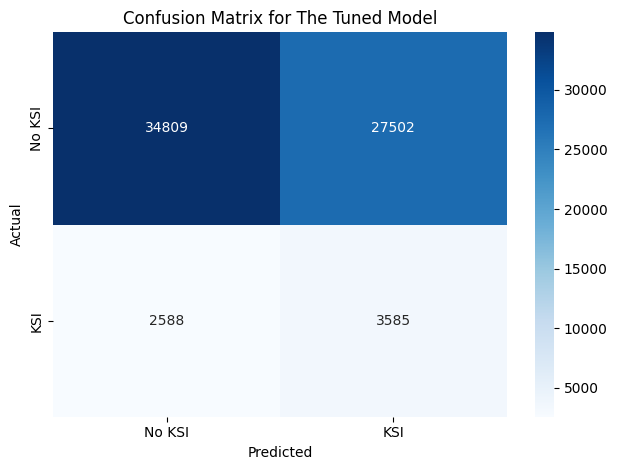

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Confusion Matrix for the tune model ---")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No KSI', 'KSI'], yticklabels=['No KSI', 'KSI'])
plt.title('Confusion Matrix for The Tuned Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
#plt.savefig('/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/figures/tunedmodel_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


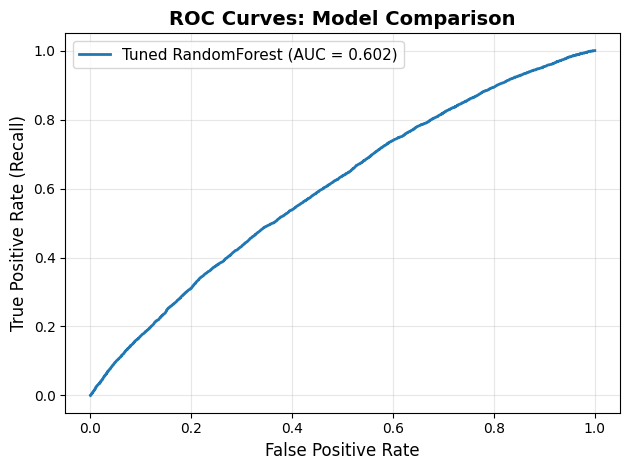

In [14]:
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned RandomForest (AUC = {tuned_auc:.3f})', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
df.columns

Index(['borough', 'crash_date', 'crash_time', 'day_of_week', 'month',
       'is_weekend', 'hour', 'hour_category', 'season', 'pedestrian_involved',
       'cyclist_involved', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'high_risk', 'KSI'],
      dtype='object')

### Best Model: 
- Based on the result on performance the tuned model is the best to deploy to our stakeholders because:
1. it has a better RECALL whic is very important for Safety
   - the model identifies 58.1% of severe crashes (KSI events)
   - For Vision Zero, catching dangerous collisions is more critical than avoiding false alarms (false positve)
   - Missing a KSI event has severe consequences (deaths/injuries). 
2. BALANCED PERFORMANCE
   - Precision: 0.115 - most predictions are correct
   - F1-Score: 0.192 - good balance
   - ROC-AUC: 0.602 - strong overall discrimination
3. ACTIONABLE INSIGHTS
   - Feature importance shows which factors matter most. Here in our case, `hour`, `high_risk`, `cyclist_involved`, `borough_Manhattan`, `pedestrian_involved ` are the top 5 best features predicting Killed or Serious Injured.
   - Can identify high-risk scenarios for intervention.
4.  DEPLOYMENT
   - This model can predict KSI risk in real-time from crash reports
   - Helps prioritize emergency response
   - Guides resource allocation and policy decisions

### Clustering

- First let's select the features for creating the clusters

In [16]:
cluster_features_num =  ['hour', 'day_of_week', 'pedestrian_involved', 'cyclist_involved','high_risk']
cluster_features_cat = ['borough', 'hour_category', 'season']

In [17]:
df_cluster = df.copy()
df_cluster['KSI'] = df['KSI']

In [18]:
sample_size = min(20000, len(df_cluster)) #build the clusters in this sample for faster clustering because the data is too big, more 300 thousands rows
df_cluster_sample = df_cluster.sample(n=sample_size, random_state=42)

In [19]:
# One-hot encode categorical features for clustering
from sklearn.preprocessing import OneHotEncoder

encoder_cluster = OneHotEncoder(sparse_output=False, drop='first')

cat_encoded_sample = encoder_cluster.fit_transform(df_cluster_sample[cluster_features_cat])
X_cluster_sample = np.hstack([
    df_cluster_sample[cluster_features_num].values,
    cat_encoded_sample
])

scaler_cluster = StandardScaler()
X_cluster_scaled_sample = scaler_cluster.fit_transform(X_cluster_sample)

In [20]:
encoder_cluster

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20",'auto'
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",'first'
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",False
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'error'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.1 Read more in the :ref:`User Guide `.",None
,"max_ca

In [21]:
df[cluster_features_num].values

array([[ 1,  2,  0,  0,  0],
       [16,  3,  0,  0,  0],
       [21,  3,  0,  0,  0],
       ...,
       [10,  3,  0,  0,  0],
       [10,  0,  0,  0,  0],
       [11,  1,  1,  0,  0]])

- we have all our categorical data encoded as binary and scalled to prevente high differences between small and large value.

In [22]:
#cluster_feature_names = cluster_features_num + list(cat_feature_names)


In [23]:
K_range = range(3, 13)
inertias = []
silhouettes = []

for k in K_range:
    print(f"  Testing k={k}...", end=' ')
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled_sample)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_cluster_scaled_sample, kmeans.labels_)
    silhouettes.append(sil_score)
    print(f"Silhouette: {sil_score:.3f}")

  Testing k=3... Silhouette: 0.168
  Testing k=4... Silhouette: 0.189
  Testing k=5... Silhouette: 0.166
  Testing k=6... Silhouette: 0.174
  Testing k=7... Silhouette: 0.188
  Testing k=8... Silhouette: 0.166
  Testing k=9... Silhouette: 0.194
  Testing k=10... Silhouette: 0.169
  Testing k=11... Silhouette: 0.175
  Testing k=12... Silhouette: 0.179


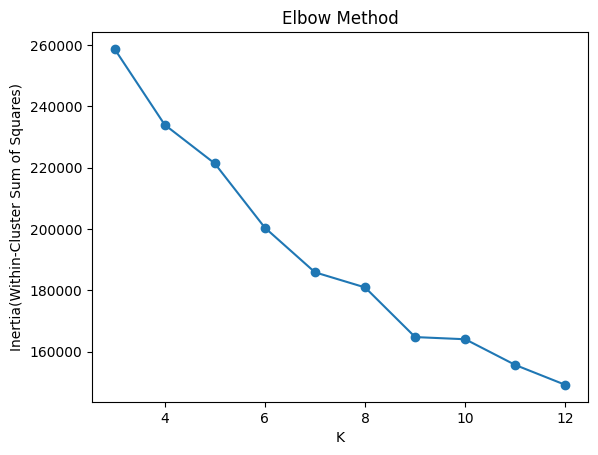

In [24]:
# Let's plot Elbow 
plt.plot(K_range, inertias, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia(Within-Cluster Sum of Squares)")
plt.title("Elbow Method")
plt.show()

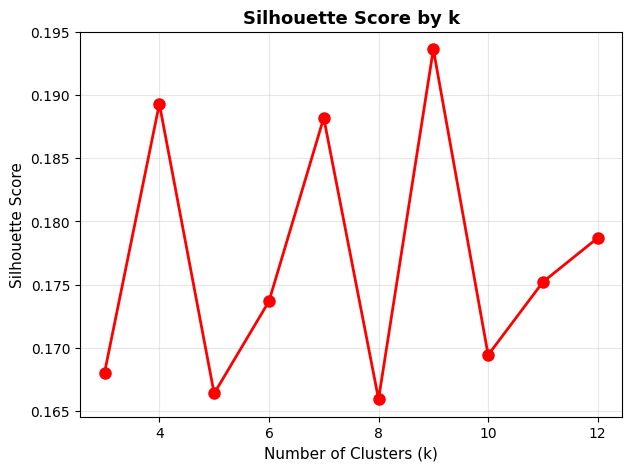

In [25]:
# Let's plot silhouette scores
fig, ax = plt.subplots(figsize=(7, 5))

plt.plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=11)
plt.ylabel('Silhouette Score', fontsize=11)
plt.title('Silhouette Score by k', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)

- K is equal to the highest silhouhette which is equal to 9 in the plot. 

In [26]:
# Now fit the clustering model on the training set
kmeans_final = KMeans(n_clusters=9, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_cluster_scaled_sample)

In [27]:
kmeans_final

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",9
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",10
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [28]:
clusters

array([0, 4, 4, ..., 4, 7, 1], dtype=int32)

In [29]:
df_cluster_sample['cluster'] = clusters

In [30]:
cluster_summary = df_cluster_sample.groupby('cluster').agg(
    Total_Crashes=('KSI', 'count'),
    KSI_Count=('KSI', 'sum'),
    KSI_Rate=('KSI', 'mean'),
    Avg_Hour=('hour', 'mean'),
    Avg_Day=('day_of_week', 'mean')
).round(3)

In [31]:
cluster_boroughs = df_cluster_sample.groupby('cluster')['borough'].agg(
    lambda x: x.value_counts().index[0] if len(x) > 0 else 'Unknown'
)

cluster_hour_cat = df_cluster_sample.groupby('cluster')['hour_category'].agg(
    lambda x: x.value_counts().index[0] if len(x) > 0 else 'Unknown'
)
cluster_season = df_cluster_sample.groupby('cluster')['season'].agg(
    lambda x: x.value_counts().index[0] if len(x) > 0 else 'Unknown'
)

cluster_summary['Ped_invol_rate'] = df_cluster_sample.groupby('cluster')['pedestrian_involved'].mean().round(3)


In [32]:
cluster_summary

,Total_Crashes,KSI_Count,KSI_Rate,Avg_Hour,Avg_Day,Ped_invol_rate
cluster,,,,,,
0,4277,446,0.104,14.559,2.882,0.000
1,1644,170,0.103,16.136,2.898,0.000
2,2697,211,0.078,7.691,2.649,0.000
3,2181,271,0.124,21.420,3.207,0.000
4,2888,295,0.102,2.045,3.604,0.050
5,2990,235,0.079,14.879,2.880,0.000
6,1087,54,0.050,13.925,2.927,0.007
7,1724,113,0.066,14.783,2.778,1.000
8,512,26,0.051,13.076,2.854,0.115


In [33]:
cluster_boroughs

cluster
0         Brooklyn
1           Queens
2         Brooklyn
3         Brooklyn
4         Brooklyn
5        Manhattan
6        Manhattan
7         Brooklyn
8    Staten Island
Name: borough, dtype: object

In [34]:
cluster_hour_cat

cluster
0          Midday
1          Midday
2    Morning_Rush
3           Night
4      Late_Night
5          Midday
6          Midday
7          Midday
8          Midday
Name: hour_category, dtype: object

In [35]:
cluster_season

cluster
0    Spring
1    Summer
2    Spring
3    Spring
4    Summer
5    Summer
6    Summer
7      Fall
8      Fall
Name: season, dtype: object

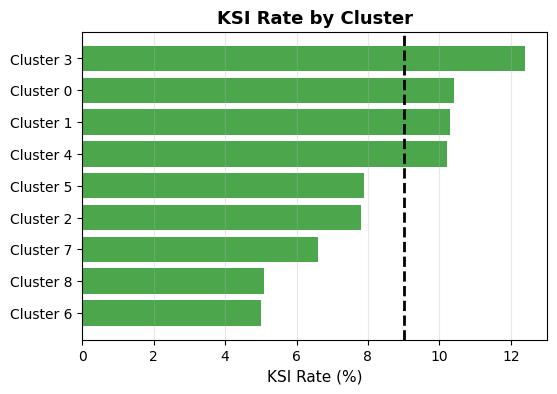

In [36]:
fig, ax = plt.subplots(figsize=(6, 4))
# 1. KSI Rate by Cluster
cluster_plot = cluster_summary.sort_values('KSI_Rate', ascending=True)

ax.barh(range(len(cluster_plot)), cluster_plot['KSI_Rate'] * 100, color='green', alpha=0.7)
ax.set_yticks(range(len(cluster_plot)))
ax.set_yticklabels([f'Cluster {c}' for c in cluster_plot.index])
ax.axvline(x=df_cluster['KSI'].mean() * 100, color='black', linestyle='--', 
                   linewidth=2, label='Overall KSI Rate')
ax.set_xlabel('KSI Rate (%)', fontsize=11)
ax.set_title('KSI Rate by Cluster', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

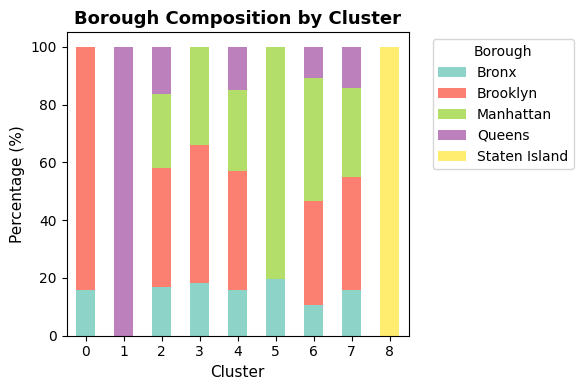

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# 2. Borough Distribution by Cluster (Single Plot)
borough_cluster = (pd.crosstab(
        df_cluster_sample['cluster'],
        df_cluster_sample['borough'],
        normalize='index') * 100
)

fig, ax = plt.subplots(figsize=(6, 4))

borough_cluster.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='Set3'
)

ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('Borough Composition by Cluster', fontsize=13, fontweight='bold')
ax.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


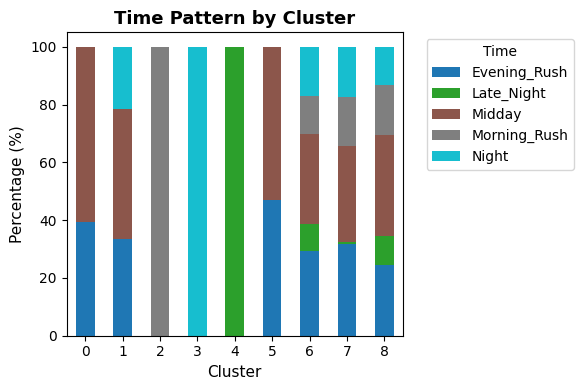

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# 3. Hour Category Distribution by Cluster (Single Plot)
hour_cluster = (pd.crosstab(
        df_cluster_sample['cluster'],
        df_cluster_sample['hour_category'],
        normalize='index') * 100
)

fig, ax = plt.subplots(figsize=(6, 4))

hour_cluster.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='tab10'
)

ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('Time Pattern by Cluster', fontsize=13, fontweight='bold')
ax.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()



CLUSTERING INSIGHTS:
  - Identified 9 distinct collision behavior patterns
  - Silhouette score of 0.194 indicates moderate cluster separation
  - 4 high-risk pattern(s) identified (KSI rate > 9.014%):
    - Cluster 0: Brooklyn crashes during Midday
    - Cluster 1: Queens crashes during Midday
    - Cluster 3: Brooklyn crashes during Night
    - Cluster 4: Brooklyn crashes during Late_Night
  - Behavioral clustering reveals distinct crash typologies by borough and time

#### Final Step:
- let's Pickle the Tuned Model for the App

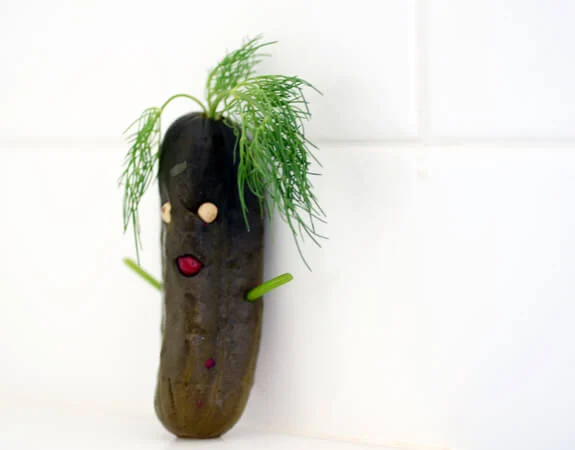

In [39]:
# Save the tuned model
import joblib

joblib.dump(tuned_model, '/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/final_model.pkl')

# Save the clustering model and scaler
joblib.dump(kmeans_final, '/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/clustering_model.pkl')
joblib.dump(scaler_cluster, '/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/clustering_scaler.pkl')

['/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/clustering_scaler.pkl']

In [40]:
# Let's create the METADATA for STREAMLIT APP

# Get feature importance for top features
feature_names_encoded = (numerical_features + 
                        list(tuned_model.named_steps['preprocessor']
                        .named_transformers_['cat'].get_feature_names_out(categorical_features)))

In [41]:
importances = tuned_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names_encoded,
    'importance': importances
}).sort_values('importance', ascending=False).head(5)

In [42]:

# Create metadata dictionary
meta = {
    "test_accuracy": float(tuned_accuracy),
    "test_recall": float(tuned_recall),
    "test_precision": float(tuned_precision),
    "test_f1": float(tuned_f1),
    "test_auc": float(tuned_auc),
    "boroughs": df['borough'].unique().tolist(),
    "hour_categories": df['hour_category'].unique().tolist(),
    "seasons": df['season'].unique().tolist(),
    "ksi_rate": float(df['KSI'].mean()),
    "total_crashes": int(len(df)),
    "feature_names": all_features,
    "top_features": feature_importance_df.to_dict('records')
}


In [43]:
# Save metadata to JSON file
import json
with open("/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/app/ksi_model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

### Let's go deploy the App!
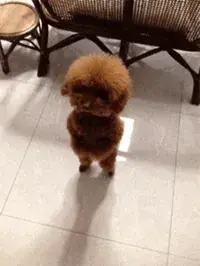